# PBEE Framework

Fan Hu, Spring 2021

Modified from the PBEE Matlab file `PEERPBEE_SIPs.m` by Selim Gunay

### Import Modules

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import lognorm
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale = 1.0)
# rc={'figure.figsize':(12,8)}
# plt.rc('figure', dpi=100, figsize=(7, 5))
# plt.rc('font', size=12)
rng = np.random.default_rng()

### Hazard Analysis 
No probability distribution is considered for the hazard in this file. Only single intensity levels are considered.

In [2]:
Sa1 = [1.0]    # Placeholder for MCE
fhaz = [1.0]   # Assign 1.0 to the above Sa1 value to consider only that  
numIM = np.size(Sa1)

### Structural Analysis

`PRA`: maximum floor acceleration (unit: g)

`MIDR`: maximum interstory drift ratio; `MIDRroof`: maximum roof drift ratio

`MED`: median; `COV`: coefficient of variation $CV = \frac{\sigma}{\mu}$

In [3]:
EDPs_orig = pd.read_csv('EDPs.txt', header = None, delimiter = "\t")
EDPs = EDPs_orig.set_index(0).rename_axis('Sas').rename(columns={1: "MEDPRA", 2: "COVPRA", 3: "MEDMIDR", 4: 'COVMIDR', 5: 'MEDMIDRroof', 6: 'COVMIDRroof'})
EDPs.head()

,MEDPRA,COVPRA,MEDMIDR,COVMIDR,MEDMIDRroof,COVMIDRroof
Sas,,,,,,
1,1,0.4,0.02,0.4,0.022,0.4
2,1,0.4,0.02,0.4,0.022,0.4
3,1,0.4,0.02,0.4,0.022,0.4
4,1,0.4,0.02,0.4,0.022,0.4
5,1,0.4,0.02,0.4,0.022,0.4


Two damagable groups are assumed 1) structural components, 2) non-structural components

`MIDR` is accepted as the EDP for group 1; `Peak Roof Acceleration (PRA)` is accepted as the EDP for group 2

The PDF for `lognormal` is: $$f(x,s) = \frac{1}{sx\sqrt{2\pi}}exp(-\frac{log^2(x)}{2s^2})$$
for $x>0, s>0$. `lognorm.pdf(x, s, loc, scale)` is identically equivalent to `lognorm.pdf(y, s) / scale` with `y = (x - loc) / scale`.

In [4]:
MEDMIDRf = []; COVMIDRf = []; MEDPRAf = []; COVPRAf = [];

mulogIDR = []; siglogIDR = []; Fstrans = []; # IDR
mulogflracc = []; siglogflracc = []; Fstranns = []; # PFA

for i in np.arange(numIM):
    
    if Sa1[i] == 0: 
        MEDMIDRf.append(0)
        COVMIDRf.append(0)
        MEDPRAf.append(0)
        COVPRAf.append(0)
    else:
        MEDMIDRf.append(EDPs['MEDMIDR'].iloc[i])
        COVMIDRf.append(EDPs['COVMIDR'].iloc[i])
        MEDPRAf.append(EDPs['MEDPRA'].iloc[i])
        COVPRAf.append(EDPs['COVPRA'].iloc[i])
    
    # Interstory Drift Ratio (for structural damagable group)
    mulogIDR.append(np.log(MEDMIDRf[i]))
    siglogIDR.append(np.sqrt(np.log(1 + COVMIDRf[i] ** 2)))
    
    IDRvec = np.linspace(0, 0.10, num = 200) # use the following line to check the start and stop points
    # [lognorm.ppf(0.001, siglogIDR[i], scale = MEDMIDRf[i]), lognorm.ppf(0.999, siglogIDR[i], scale = MEDMIDRf[i])]
    Fstrans.append(lognorm.cdf(IDRvec, siglogIDR[i], loc = 0, scale = MEDMIDRf[i]))
    
    # Peak Floor Acceleration 
    mulogflracc.append(np.log(MEDPRAf[i]))
    siglogflracc.append(np.sqrt(np.log(1 + COVPRAf[i] ** 2)))
    
    flraccvec = np.linspace(0, 4.0, num = 200) # use the following line to check the start and stop points
    # [lognorm.ppf(0.001, siglogIDR[i], scale = MEDPRAf[i]), lognorm.ppf(0.999, siglogIDR[i], scale = MEDPRAf[i])]
    Fstranns.append(lognorm.cdf(flraccvec, siglogflracc[i], loc = 0, scale = MEDPRAf[i]))
    

### Damage Analysis 

Lognormal distribution is assumed for the probability of exceedance of damage states. 

Three damage states for `Interstory Drift (structural damagable group)` are assumed: 1) **slight damage**, 2) **moderate damage**, 3) **severe damage**.

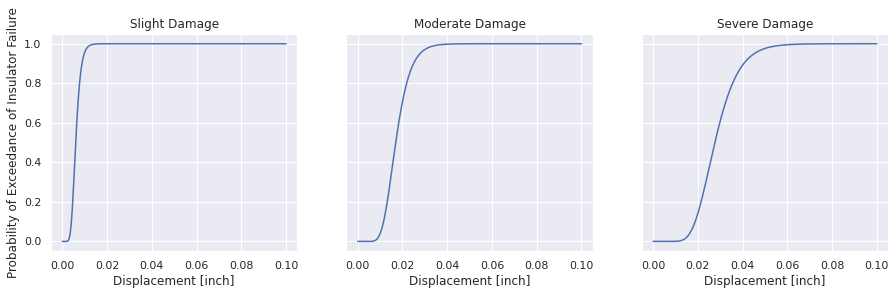

In [5]:
MEDdams = [0.0060, 0.0170, 0.0276]
COVdams = [0.30, 0.30, 0.30]

numIDR = IDRvec.size
MEDlogdams = np.log(MEDdams)
SIGlogdams = COVdams

Fdams = [];
for i in np.arange(0, 3):
    Fdams.append(lognorm.cdf(IDRvec, SIGlogdams[i], loc = 0, scale = MEDdams[i]))
    
fig, ax = plt.subplots(1, 3, figsize = (15, 4), sharey=True)
# fig.suptitle(' ')

sns.lineplot(ax = ax[0], x = IDRvec, y = Fdams[0])
ax[0].set_title('Slight Damage')
ax[0].set(xlabel = 'Displacement [inch]', ylabel = 'Probability of Exceedance of Insulator Failure')

sns.lineplot(ax = ax[1], x = IDRvec, y = Fdams[1])
ax[1].set_title('Moderate Damage')
ax[1].set(xlabel = 'Displacement [inch]')

sns.lineplot(ax = ax[2], x = IDRvec, y = Fdams[2])
ax[2].set_title('Severe Damage')
ax[2].set(xlabel = 'Displacement [inch]');

Two damage states for `PRA (nonstructural damagable group)` are assumed: 1) **DM = 5 cm**, 2) **DM = 10 cm**.

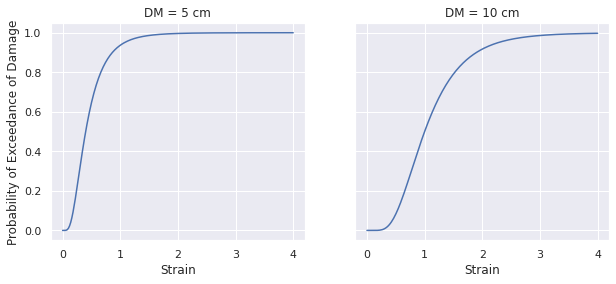

In [6]:
MEDdamns = [0.4, 1.0]
COVdamns = [0.6, 0.5]

numPRA = flraccvec.size
MEDlogdamns = np.log(MEDdamns)
SIGlogdamns = COVdamns

Fdamns = [];
for i in np.arange(0, 2):
    Fdamns.append(lognorm.cdf(flraccvec, SIGlogdamns[i], loc = 0, scale = MEDdamns[i]))
    
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey=True)
# fig.suptitle(' ')

sns.lineplot(ax = ax[0], x = flraccvec, y = Fdamns[0])
ax[0].set_title('DM = 5 cm')
ax[0].set(xlabel = 'Strain', ylabel = 'Probability of Exceedance of Damage')

sns.lineplot(ax = ax[1], x = flraccvec, y = Fdamns[1])
ax[1].set_title('DM = 10 cm')
ax[1].set(xlabel = 'Strain'); 


### Loss Analysis 

Lognormal distribution is assumed for the economic loss given a damage state.

For the `structural damagable group`, three median and three COV values are assumed for the assumed three damage states: 1) **slight damage**, 2) **moderate damage**, 3) **severe damage**

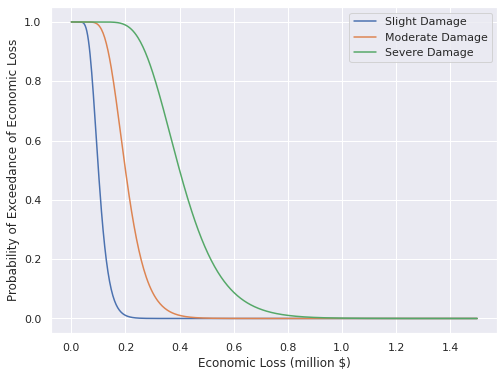

In [7]:
MEDlosss = [0.1, 0.2, 0.4]
COVlosss = [0.30, 0.30, 0.30]

MEDloglosss = np.log(MEDlosss)
SIGloglosss = COVlosss

Flosss1, Flosss = [], [];
loss_vec = np.linspace(0, 1.5, num = 500)
for i in np.arange(0, 3): 
    Flosss1.append(lognorm.cdf(loss_vec, SIGloglosss[i], loc = 0, scale = MEDlosss[i]))
    Flosss.append(1 - Flosss1[i])
    
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
sns.set(font_scale = 1.0)

sns.lineplot(x = loss_vec, y = Flosss[0], label = 'Slight Damage')
sns.lineplot(x = loss_vec, y = Flosss[1], label = 'Moderate Damage')
sns.lineplot(x = loss_vec, y = Flosss[2], label = 'Severe Damage')

ax.set(title = '', xlabel = 'Economic Loss (million $)', ylabel = 'Probability of Exceedance of Economic Loss');

For `nonstructural damagable group`, two median and two COV values are for the assumed two damage states: 1) **DM = 5 cm**, 2) **DM = 10 cm**

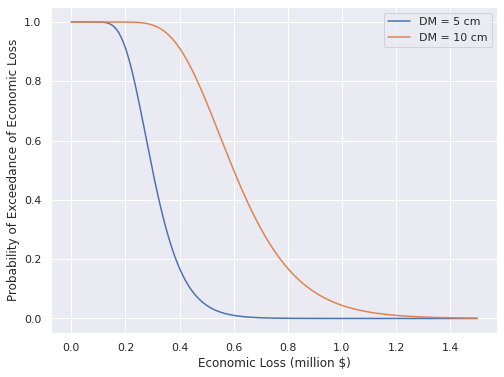

In [8]:
MEDlossns = [0.3, 0.6]
COVlossns = [0.30, 0.30]

MEDloglossns = np.log(MEDlossns)
SIGloglossns = COVlossns

Flossns1, Flossns = [], [];
loss_vec = np.linspace(0, 1.5, num = 500)
for i in np.arange(0, 2): 
    Flossns1.append(lognorm.cdf(loss_vec, SIGloglossns[i], loc = 0, scale = MEDlossns[i]))
    Flossns.append(1 - Flossns1[i])
    
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
sns.set(font_scale = 1.0)

sns.lineplot(x = loss_vec, y = Flossns[0], label = 'DM = 5 cm')
sns.lineplot(x = loss_vec, y = Flossns[1], label = 'DM = 10 cm')

ax.set(title = '', xlabel = 'Economic Loss (million $)', ylabel = 'Probability of Exceedance of Economic Loss');

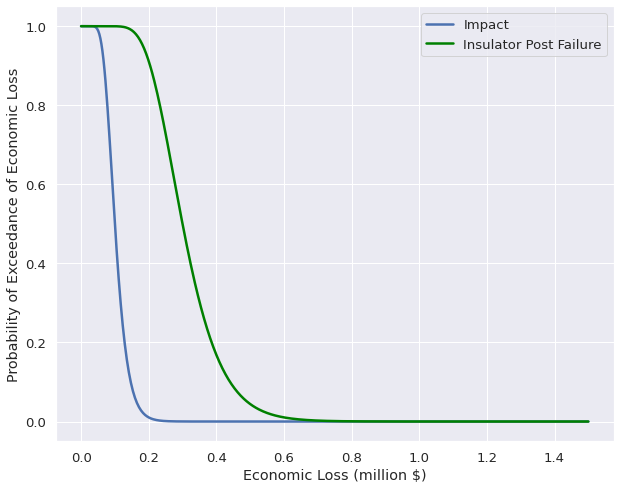

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
sns.set(font_scale = 1.2)

sns.lineplot(x = loss_vec, y = Flosss[0], label = 'Impact', linewidth=2.5)
sns.lineplot(x = loss_vec, y = Flossns[0], label = 'Insulator Post Failure', color='green', linewidth=2.5)
ax.set(title = '', xlabel = 'Economic Loss (million $)', ylabel = 'Probability of Exceedance of Economic Loss');

Loss for `collapse`:

In [13]:
MEDlossC = 1.0
COVlossC = 0.10
MEDloglosC = np.log(MEDlossC)
SIGloglosC = COVlossC

loss_vec = np.linspace(0, 1.5, num = 500)
FlosC1 = lognorm.cdf(loss_vec, SIGloglosC, loc = 0, scale = MEDlossC)
FlosC = 1.0 - FlosC1

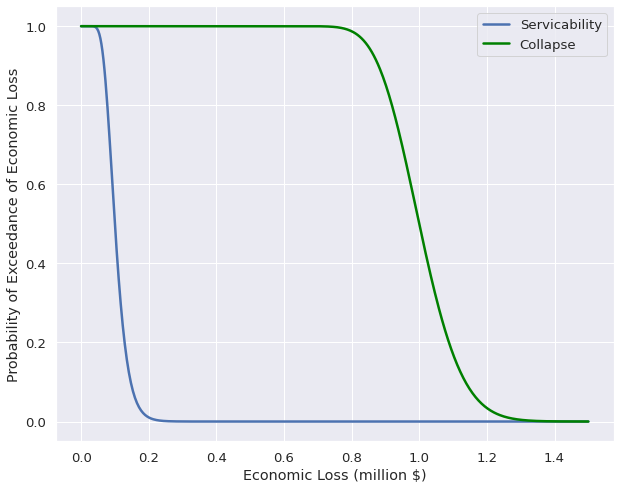

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
sns.set(font_scale = 1.2)

sns.lineplot(x = loss_vec, y = Flosss[0], label = 'Servicability', linewidth=2.5)
sns.lineplot(x = loss_vec, y = FlosC, label = 'Collapse', color='green', linewidth=2.5)
ax.set(title = '', xlabel = 'Economic Loss (million $)', ylabel = 'Probability of Exceedance of Economic Loss');